## 中文文本分类模型

### 0.环境准备

In [4]:
# 导入所需的库
import jieba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import rcParams

# 设置支持中文的字体
rcParams['font.sans-serif'] = ['SimHei']  # 黑体
rcParams['axes.unicode_minus'] = False  # 显示负号

### 1.数据加载

In [5]:
# 读取数据集
data = pd.read_csv('filtered_cnews.train.txt', sep='\t', header=None, names=['label', 'text'])

# 查看数据集基本信息
# 每个类别的前五条数据
grouped_data = data.groupby('label').head(5)
print(grouped_data)
# 显示数据集的基本信息
print(data.info())

      label                                               text
0        体育  马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...
1        体育  商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...
2        体育  冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...
3        体育  辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...
4        体育  揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道  谢亚龙已经被公安...
5000     家居  家装减碳从点滴来做起 实现家居装修低碳的目标“低碳节能”之风吹遍大江南北的时候，也深入家装人...
5001     家居  昆明慕思启幕盛典暨2011慕思探索欧洲睡眠文化之旅闪动春城(新浪乐居房产讯 编辑/李秀婷)7...
5002     家居   如何利用风水来规划自己的新房主持人：接下来给我们讲讲怎样规划一个房子？张定?：我们在规划的...
5003     家居  10分钟精通卫生间装修(组图)现代生活中卫生间不仅是方便、洗尽身上尘垢的地方，也是调剂身心、...
5004     家居  12万打造140平都市田园风家园(组图)田园风格成为现代人喜爱的一种风格之一，在碎花与绿草中...
10000    房产  公园1872之夜暨招商地产25周年庆典酒会(组图)    2009年4月25日19：00，地...
10001    房产  实录：中景江山赋开篇提序盛典(组图)图为中景·江山赋沙盘陈亦耕：尊敬的各位领导，各位来宾，新...
10002    房产  设计体现国粹精髓 中景江山赋正式亮相(组图)图为中铁电气化局集团工会主席、副总经理蒋玉林图为...
10003    房产  王广善：别墅产品是社会和经济发展的标志(图)时间：2009年4月29日14：00地点：理想国...
10004    房产  九号院花园洋房5月开盘起价3780元(图)第二站：九号院花园洋房 (论坛 相册 户型

### 2.中文预处理（文本分词与去停用词）

In [6]:
# 加载停用词
def load_stopwords():
    with open('stopwords.txt', 'r', encoding='utf-8') as f:
        return set(f.read().splitlines())

stopwords = load_stopwords()

# 使用jieba库对中文文本进行分词
def jieba_tokenizer(text):
    words = jieba.cut(text)
    return ' '.join([word for word in words if word not in stopwords])

# 查看预处理后的数据
data['text_processed'] = data['text'].apply(jieba_tokenizer)
print(data[['text', 'text_processed']].head())

                                                text  \
0  马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...   
1  商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...   
2  冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...   
3  辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...   
4  揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道  谢亚龙已经被公安...   

                                      text_processed  
0  马晓旭 意外 受伤 国奥 警惕   无奈 大雨 青睐 殷家 军 记者 傅亚雨 沈阳 报道  ...  
1  商瑞华 首战 复仇 心切   中国 玫瑰 美国 方式 攻克 瑞典 多曼来 瑞典 商瑞华 首战...  
2  冠军 球队 迎新 欢乐 派对   黄旭获 大奖 张军 赢 PK 赛 新浪 体育讯 12 月 ...  
3  辽足 签约 危机 引 注册 难关   高层 威逼利诱 合同 笑里藏刀 新浪 体育讯 月 24...  
4  揭秘 谢亚龙 带走 总局 电话 骗局   复制 南杨 轨迹 体坛周报 特约记者 张锐 北京 ...  


### 3.数据集划分

训练集大小: 24000
验证集大小: 3000
测试集大小: 3000
训练集每个类别的样本数量：
label
科技    4000
教育    4000
财经    4000
体育    4000
家居    4000
房产    4000
Name: count, dtype: int64
验证集每个类别的样本数量：
label
房产    500
科技    500
教育    500
财经    500
体育    500
家居    500
Name: count, dtype: int64
测试集每个类别的样本数量：
label
体育    500
家居    500
科技    500
教育    500
财经    500
房产    500
Name: count, dtype: int64


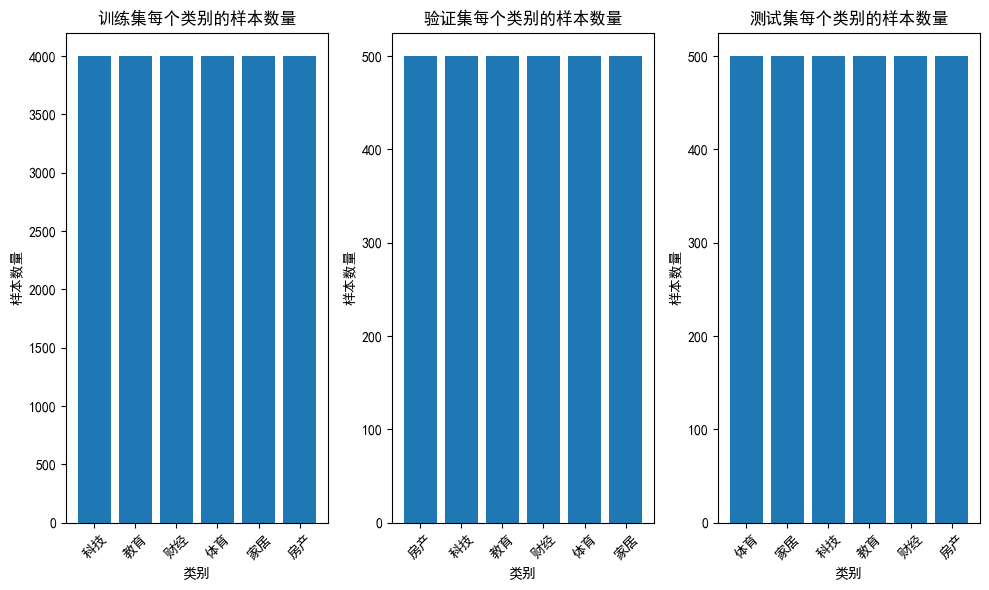

In [7]:
# 划分数据集
X = data['text_processed']
y = data['label']

# 划分训练集和临时数据集（80%，20%）
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

# 划分验证集和测试集（50%，50%）
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp,random_state=42)

# 输出预处理后的数据情况
print(f"训练集大小: {len(X_train)}")
print(f"验证集大小: {len(X_val)}")
print(f"测试集大小: {len(X_test)}")
# 输出每个类别的样本分布
print("训练集每个类别的样本数量：")
print(y_train.value_counts())
print("验证集每个类别的样本数量：")
print(y_val.value_counts())
print("测试集每个类别的样本数量：")
print(y_test.value_counts())
# 可视化每个类别的样本分布
# 训练集
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.bar(y_train.value_counts().index, y_train.value_counts().values)
plt.xlabel('类别')
plt.ylabel('样本数量')
plt.title('训练集每个类别的样本数量')
# 验证集
plt.xticks(rotation=45)
plt.subplot(1, 3, 2)
plt.bar(y_val.value_counts().index, y_val.value_counts().values)
plt.xlabel('类别')
plt.ylabel('样本数量')
plt.title('验证集每个类别的样本数量')
# 测试集
plt.xticks(rotation=45)
plt.subplot(1, 3, 3)
plt.bar(y_test.value_counts().index, y_test.value_counts().values)
plt.xlabel('类别')
plt.ylabel('样本数量')
plt.title('测试集每个类别的样本数量')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.文本特征提取（TF-IDF）

In [11]:
# 使用TF-IDF提取特征
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1, 2),min_df=5,max_df=0.8)

# 向量化训练集、验证集、测试集
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# 输出特征的维度
print(f"训练集特征维度: {X_train_tfidf.shape}")
print(f"验证集特征维度: {X_val_tfidf.shape}")
print(f"测试集特征维度: {X_test_tfidf.shape}")

训练集特征维度: (24000, 5000)
验证集特征维度: (3000, 5000)
测试集特征维度: (3000, 5000)


### 5.分类模型训练

In [12]:
# Naive Bayes(朴素贝叶斯)
# 创建并训练朴素贝叶斯分类器
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
# 模型预测
y_pred_nb = nb_model.predict(X_test_tfidf)

# KNN
# 创建并训练KNN分类器
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tfidf, y_train)
# 模型预测
y_pred_knn = knn_model.predict(X_test_tfidf)

# GBDT
# 创建并训练GBDT分类器
gbdt_model = GradientBoostingClassifier(n_estimators=100)
gbdt_model.fit(X_train_tfidf, y_train)
# 模型预测
y_pred_gbdt = gbdt_model.predict(X_test_tfidf)

### 6.模型评估与可视化

=== Naive Bayes 分类报告 ===
              precision    recall  f1-score   support

          体育       0.99      1.00      0.99       500
          家居       0.94      0.93      0.93       500
          房产       0.93      0.92      0.93       500
          教育       0.94      0.92      0.93       500
          科技       0.93      0.97      0.95       500
          财经       0.94      0.94      0.94       500

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000

宏平均 - 准确率: 0.95, 召回率: 0.95, F1: 0.95
微平均 - 准确率: 0.95, 召回率: 0.95, F1: 0.95


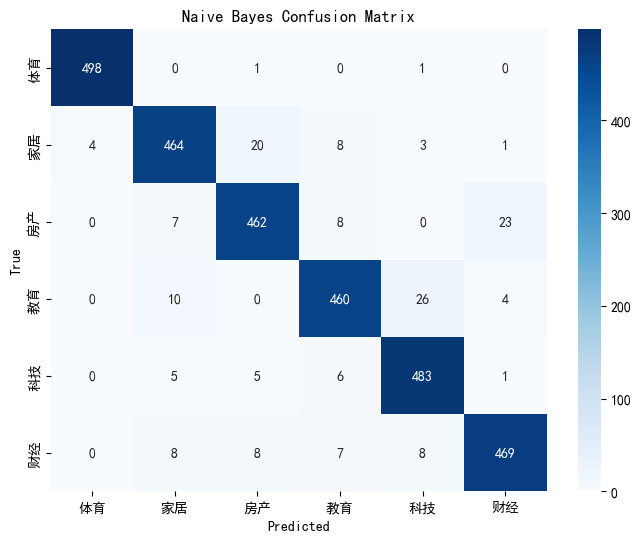

=== KNN 分类报告 ===
              precision    recall  f1-score   support

          体育       1.00      0.69      0.81       500
          家居       0.31      1.00      0.48       500
          房产       0.99      0.42      0.59       500
          教育       0.99      0.54      0.70       500
          科技       0.96      0.43      0.60       500
          财经       0.99      0.70      0.82       500

    accuracy                           0.63      3000
   macro avg       0.87      0.63      0.67      3000
weighted avg       0.87      0.63      0.67      3000

宏平均 - 准确率: 0.87, 召回率: 0.63, F1: 0.67
微平均 - 准确率: 0.87, 召回率: 0.63, F1: 0.67


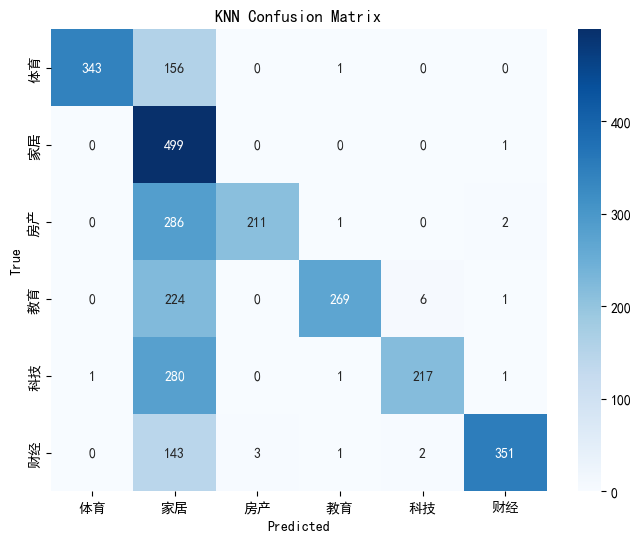

=== GBDT 分类报告 ===
              precision    recall  f1-score   support

          体育       1.00      1.00      1.00       500
          家居       0.91      0.99      0.95       500
          房产       1.00      1.00      1.00       500
          教育       0.97      0.93      0.95       500
          科技       0.96      0.92      0.94       500
          财经       0.97      0.96      0.97       500

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000

宏平均 - 准确率: 0.97, 召回率: 0.97, F1: 0.97
微平均 - 准确率: 0.97, 召回率: 0.97, F1: 0.97


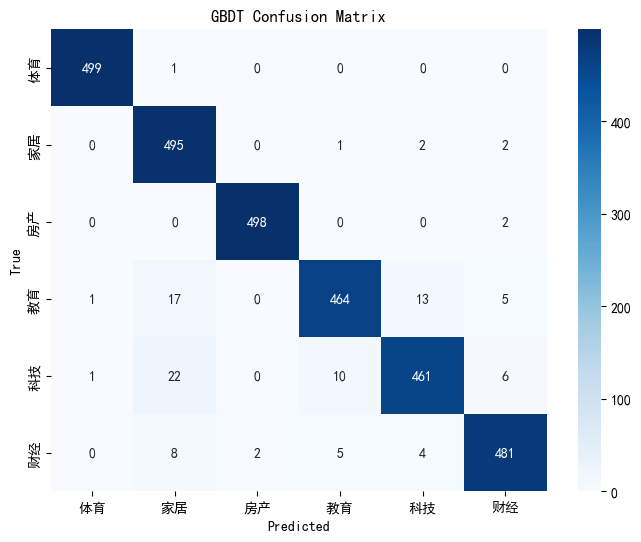

In [14]:
# 分类模型性能评估与可视化

# 计算宏平均、微平均
# 宏平均是指对每个类别的预测结果进行平均，然后计算平均的准确率、召回率、F1值等指标。
# 微平均是指对所有类别的预测结果进行平均，然后计算平均的准确率、召回率、F1值等指标。
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    print(f"=== {model_name} 分类报告 ===")
    print(classification_report(y_true, y_pred))

    # 提取宏平均和微平均的准确率、召回率、F1值
    # 宏平均
    macro_avg = report['macro avg']
    print(f"宏平均 - 准确率: {macro_avg['precision']:.2f}, 召回率: {macro_avg['recall']:.2f}, F1: {macro_avg['f1-score']:.2f}")
    # 微平均
    micro_avg = report['weighted avg']
    print(f"微平均 - 准确率: {micro_avg['precision']:.2f}, 召回率: {micro_avg['recall']:.2f}, F1: {micro_avg['f1-score']:.2f}")
    
    # 混淆矩阵
    # 混淆矩阵是一个二维矩阵，行表示真实标签，列表示预测标签。
    # 混淆矩阵的每个元素表示的是真实标签为i，预测标签为j的数量。
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    # 可视化混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data['label'].unique(), yticklabels=data['label'].unique())
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 输出分类报告和混淆矩阵

# Naive Bayes(朴素贝叶斯)模型
evaluate_model(y_test, y_pred_nb, "Naive Bayes")

# KNN模型
evaluate_model(y_test, y_pred_knn, "KNN")

# GBDT模型
evaluate_model(y_test, y_pred_gbdt, "GBDT")

### 7.结果分析


#### 7.1 模型总体性能对比
| 模型         | 准确率 (Accuracy) | 宏平均 F1-score | 微平均 F1-score | 备注                  |
|--------------|------------------|-----------------|-----------------|-----------------------|
| **朴素贝叶斯** | 0.95             | 0.95            | 0.95            | 表现稳定，各类均衡      |
| **KNN**      | 0.63             | 0.67            | 0.67            | 性能较差，严重不平衡    |
| **GBDT**     | **0.97**         | **0.97**        | **0.97**        | **性能最优**  |


#### 7.2 模型性能详细分析
##### **朴素贝叶斯 (Naive Bayes)**
- 优点：
  - 各类别的性能均衡，F1-score均在0.93以上，尤其“体育”类达到0.99。
  - 计算效率高，适合文本分类的稀疏特征。
- 缺点：
  - 准确率略低于GBDT（0.95 vs 0.97），可能因特征条件独立性假设不完全成立。

##### **KNN (K-Nearest Neighbors)**
- 问题：
  - 严重不平衡：部分类别（如“家居”）召回率1.00但精确率仅0.31，表明模型过度预测“家居”类。
  - 低泛化能力：整体准确率仅0.63。
- 可能的改进方向：
  - 尝试余弦相似度替代欧氏距离。
  - 调整K值或使用特征降维（如PCA）。

##### **GBDT (Gradient Boosting Decision Tree)**
- 优势：
  - 全面最优：所有类别的F1-score均≥0.94，且“体育”“房产”类达1.00。
  - 能捕捉非线性关系，对TF-IDF特征的交互作用建模能力强。
- 不足点：
  - 训练时间较长（100棵树），但预测性能优异。


#### 7.3 各类别性能对比
- 体育类：所有模型表现极佳（F1=1.00），可能因特征区分度高（如专有名词）。
- 家居类：
  - 朴素贝叶斯和GBDT表现良好（F1≥0.94）。
  - KNN的灾难性表现（F1=0.48）暗示该类与其他类特征重叠严重。
- 房产/财经类：GBDT显著优于其他模型，可能因决策树能捕捉经济术语的复杂模式。


#### 7.4 改进建议
- 优先选择GBDT：
   - 进一步调参（如`learning_rate`、`max_depth`）可能提升性能。
- KNN的替代方案：
   - 尝试更适合文本的模型（如SVM或神经网络）。
   - 若坚持使用KNN，需优化特征工程（如调整TF-IDF参数）。
- 朴素贝叶斯的应用场景：
   - 在实时性要求高、数据量大的场景中仍具优势。

#### 7.5 结论
**GBDT**是当前任务的最佳选择，综合性能显著优于其他模型。若需快速部署，**朴素贝叶斯**是可靠的备选方案，而**KNN**需进一步优化，考虑可能的改进方向。